In [147]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import pandas as pd

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## Part 1

In [148]:
iris = load_iris()
print(iris.DESCR)


df = pd.read_csv("./Iris_TTT4275/iris.data") ##appearantly not entirely similar to the above

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [149]:
class MSELinearClassifier:
    def __init__(self, alpha = 0.01, n_iter = 10000, threshold = 1e-3):
        self.alpha = alpha
        self.n_iter = n_iter
        self.threshold = threshold
        self.fitted = False

    def fit(self, data, targets):
        """
        Fit a linear classifier to the provided data.

        data: shape N x n_features
        targets: shape N
        """
        if data.ndim == 1:
            data = data[:, np.newaxis]


        self.fitted = True
        
        self.target_set = list(set(targets)) #to use .index() function we wrap as list
        self.n_classes = len(self.target_set)
        self.n_features = data.shape[1]
        N = data.shape[0]

        one_hot_targets = self._one_hot_encode_targets(targets)

        self.w = np.zeros((self.n_classes, self.n_features))
        self.offset = np.zeros(self.n_classes)

        data1 = np.hstack([data, np.ones((N,1))])

        pred = self.predict(data)
        for iter in range(self.n_iter):        
            
            grad_part1 = (pred - one_hot_targets)*pred*(1 - pred)

            # gradient = 0
            # for k in range(N):
            #     gradient += np.outer(grad_part1[k], data1[k])

            gradient = np.einsum('ij,ik -> jk', grad_part1, data1) #this vectorizes the above loop
            
            update = -self.alpha*gradient

            self.w += update[:, :-1]
            self.offset += update[:, -1]

            pred = self.predict(data)

            if np.linalg.norm(update) < self.threshold:
                print(f"Fitting converged after {iter} iterations.")
                break
            
        loss = self.loss(pred, one_hot_targets)
        return loss
    

    def _one_hot_encode_targets(self, targets):
        encoded = np.zeros((targets.shape[0], self.n_classes))

        for i in range(targets.shape[0]): #not neccessarily integer labels
            j = self.target_set.index(targets[i])
            encoded[i, j] = 1

        return encoded
    
    def _sigmoid(self, x):
        return 1/(1 + np.exp(-x))

    def predict(self, data, get_class = False):
        if data.ndim == 1:
            data = data[:, np.newaxis]
            
        if not self.fitted:
            raise RuntimeError("The model must be fitted before predictions can be made")
        
        one_hot_preds = self._sigmoid(self.w@data.T + self.offset[:, np.newaxis]).T

        if get_class:
            return self.get_class(one_hot_preds)
        
        return one_hot_preds
    
    def loss(self, pred, truth):
        return 0.5*np.sum((pred - truth)**2)
    
    def get_class(self, predicted):
        targets = np.array(self.target_set)
        return targets[np.argmax(predicted, axis=1)]
    
    def score(self, test_data, test_labels):
        N = len(test_labels)
        preds = self.predict(test_data, get_class=True)
        return 1 - np.count_nonzero(test_labels - preds)/N


In [150]:
def plot_confusion_matrix(conf_matrix, score = None, plot = True, filename = None):    
    plt.figure(figsize=(6,6)) #size in inches
    sns.heatmap(conf_matrix, annot=True, linewidths=.5, square = True, cmap = 'Blues_r', xticklabels=iris.target_names, yticklabels=iris.target_names)
    plt.ylabel('Actual label', size=15)
    plt.xlabel('Predicted label', size=15)
    if score is not None:
        plt.title('Accuracy Score: {fscore:.{precision}f}%'.format(fscore = score*100, precision = 1), size = 20)
    if filename is not None:
        plt.savefig(filename)
    if plot:
        plt.show()
    plt.close()

### 3/5 training set, 2/5 test set

In [151]:
training_data, test_data, training_labels, test_labels = train_test_split(iris.data, iris.target, test_size=0.4) #split the set in 3/5 training and 2/5 test

Fitting converged after 3158 iterations.
[[ 0.40975656  1.88100435 -2.69756291 -1.30847348]
 [ 0.69114261 -2.51708597  0.56181965 -2.15729765]
 [-2.48132555 -2.71309495  3.39514565  5.46301211]] [ 0.2989839   3.10509134 -2.32947448]


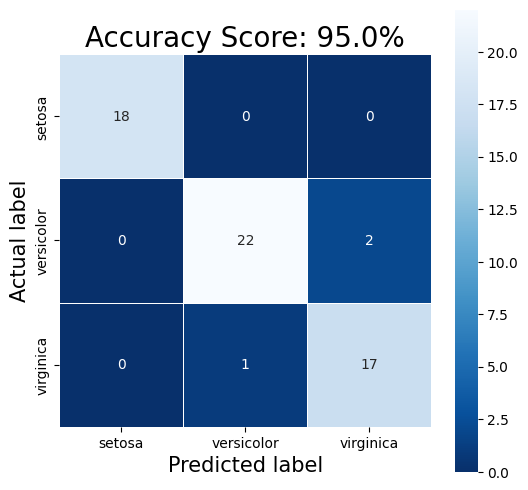

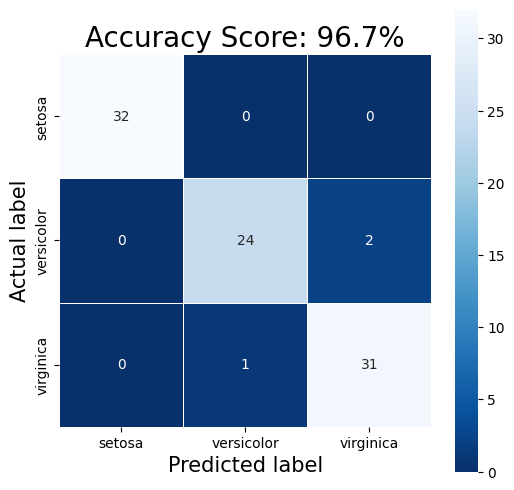

In [152]:
classifier = MSELinearClassifier()

classifier.fit(training_data, training_labels)

print(classifier.w, classifier.offset)


pred = classifier.predict(test_data, get_class = True)
score = classifier.score(test_data, test_labels)
conf_matrix = confusion_matrix(test_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="test_set_confusion_matrix.png")

pred = classifier.predict(training_data, get_class = True)
score = classifier.score(training_data, training_labels)
conf_matrix = confusion_matrix(training_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="training_set_confusion_matrix.png")

### 2/5 training set, 3/5 test set

In [153]:
training_data, test_data, training_labels, test_labels = train_test_split(iris.data, iris.target, test_size=0.6) #split the set in 2/5 training and 3/5 test

Fitting converged after 3847 iterations.
[[ 0.44488531  1.76808555 -2.69284025 -1.3121999 ]
 [ 2.5600372  -5.38985688  1.02378689 -4.51838216]
 [-3.09623673 -2.27965403  4.29160032  4.43895168]] [ 0.26316705  2.3226052  -2.24751772]


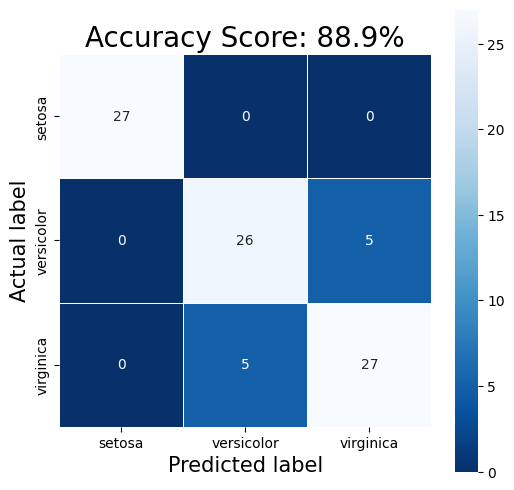

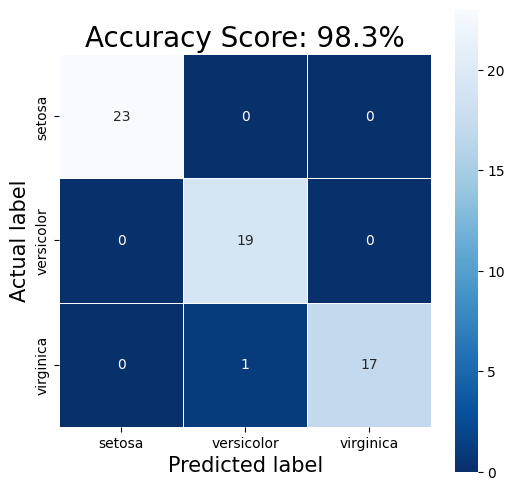

In [154]:
classifier = MSELinearClassifier()

classifier.fit(training_data, training_labels)

print(classifier.w, classifier.offset)


pred = classifier.predict(test_data, get_class = True)
score = classifier.score(test_data, test_labels)
conf_matrix = confusion_matrix(test_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="test_set_confusion_matrix.png")

pred = classifier.predict(training_data, get_class = True)
score = classifier.score(training_data, training_labels)
conf_matrix = confusion_matrix(training_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="training_set_confusion_matrix.png")

## Part 2

### Histogram of flowers per feature

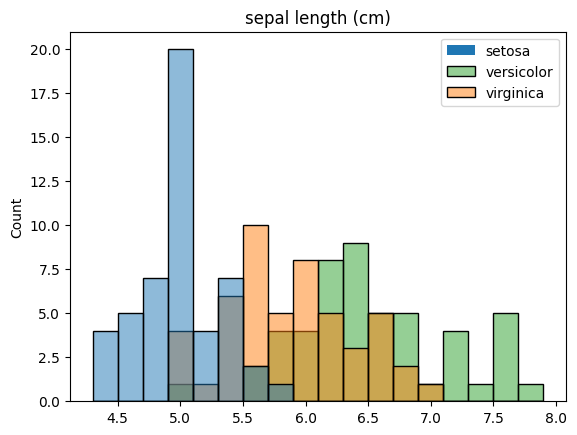

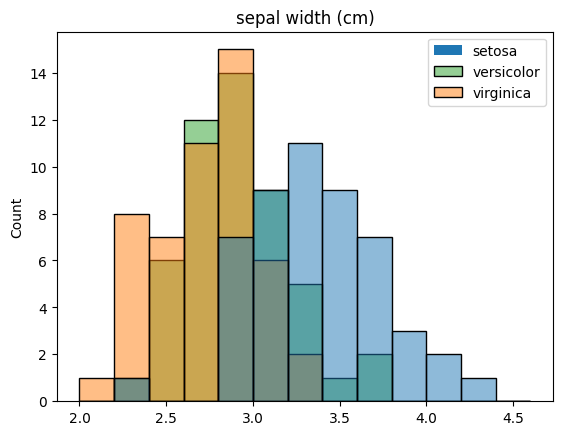

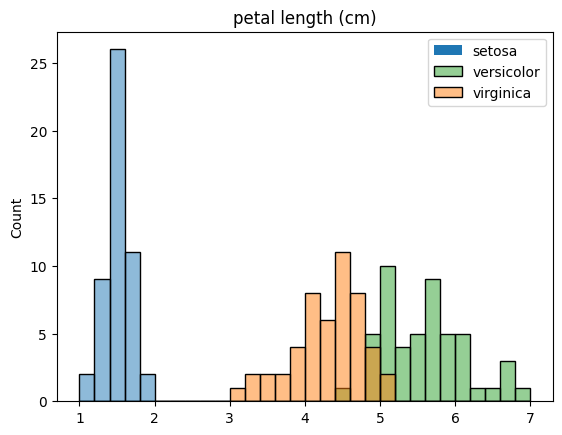

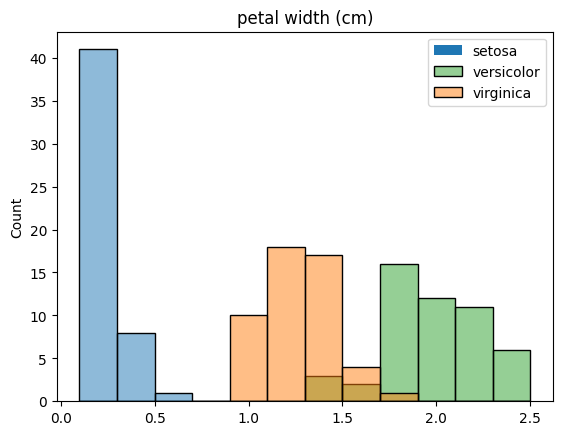

In [155]:
for i in range(len(iris.feature_names)):
    sns.histplot(iris.data[:, i].reshape(3, 50).T, binwidth=0.2)
    plt.legend(iris.target_names)
    plt.title(iris.feature_names[i])
    plt.show()

### Histogram of feature per flower, less informative than plots above

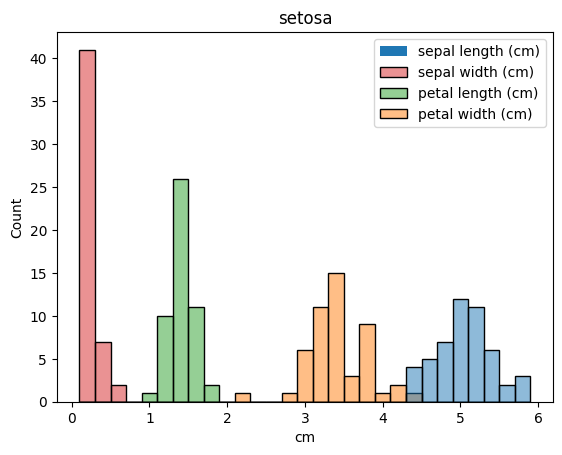

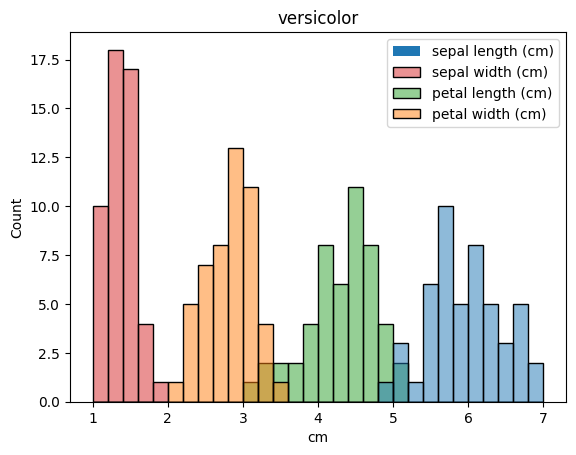

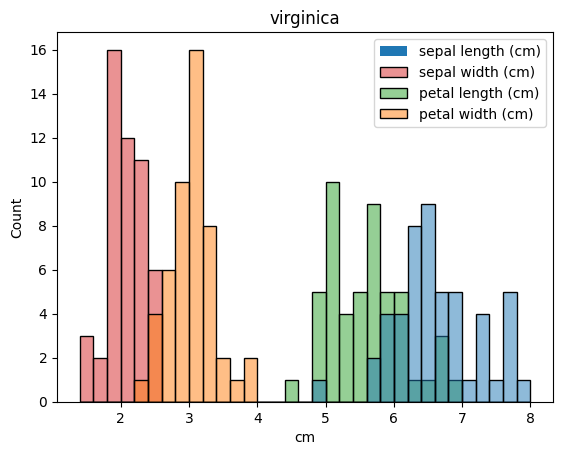

In [156]:
for i in range(len(iris.target_names)):
    sns.histplot(iris.data[iris.target == i], binwidth=0.2)
    plt.legend(iris.feature_names)
    plt.title(iris.target_names[i])
    plt.xlabel("cm")
    plt.show()

#### Feature 'sepal width' showing the most overlap. Remove it

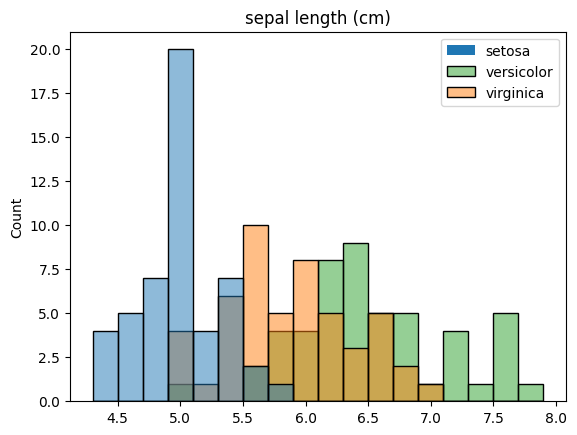

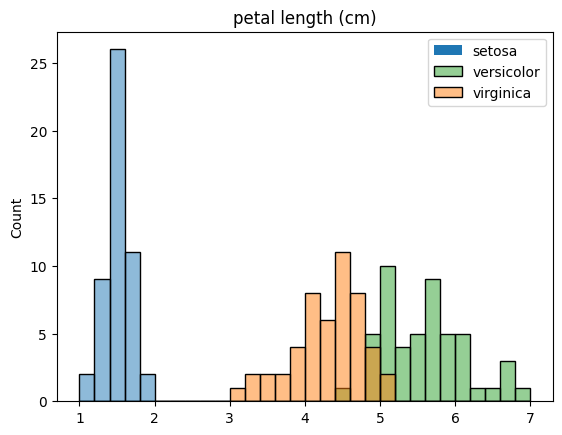

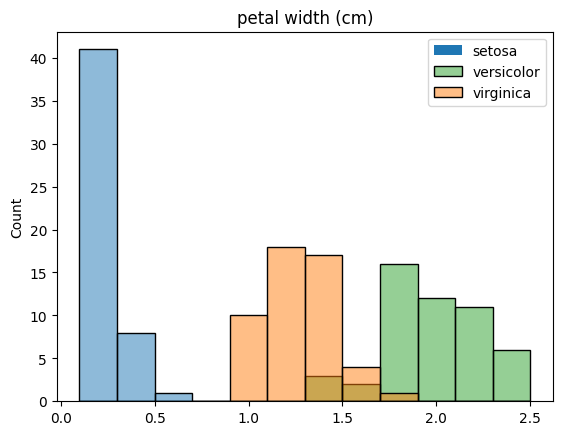

In [157]:
reduced_data = np.delete(iris.data, 1, 1)
reduced_feature_names = np.delete(iris.feature_names, 1, 0)

for i in range(len(reduced_feature_names)):
    sns.histplot(reduced_data[:, i].reshape(3, 50).T, binwidth=0.2)
    plt.legend(iris.target_names)
    plt.title(reduced_feature_names[i])
    plt.show()

In [158]:
training_data, test_data, training_labels, test_labels = train_test_split(reduced_data, iris.target, test_size=0.4)

Fitting converged after 2967 iterations.
[[ 1.77804747 -3.29228202 -1.76327524]
 [-0.99557634  1.68098463 -2.58978165]
 [-3.94720676  4.58845699  3.66760834]] [ 0.63528431  1.75048125 -3.617762  ]


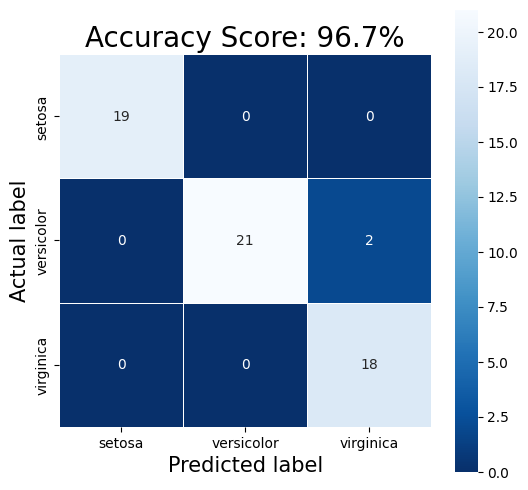

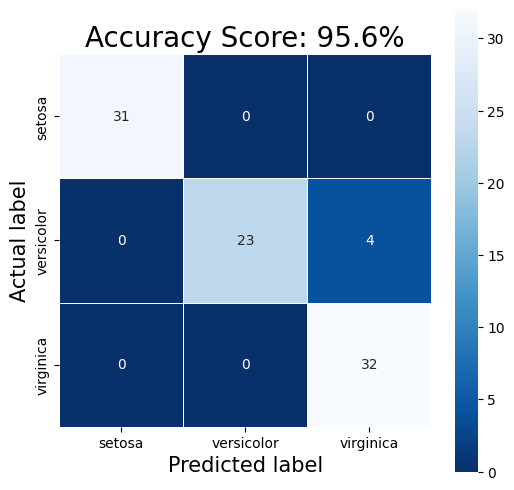

In [159]:
classifier = MSELinearClassifier()

classifier.fit(training_data, training_labels)

print(classifier.w, classifier.offset)


pred = classifier.predict(test_data, get_class = True)
score = classifier.score(test_data, test_labels)
conf_matrix = confusion_matrix(test_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="test_set_confusion_matrix.png")

pred = classifier.predict(training_data, get_class = True)
score = classifier.score(training_data, training_labels)
conf_matrix = confusion_matrix(training_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="training_set_confusion_matrix.png")

### Sepal length overlapping. Remove it

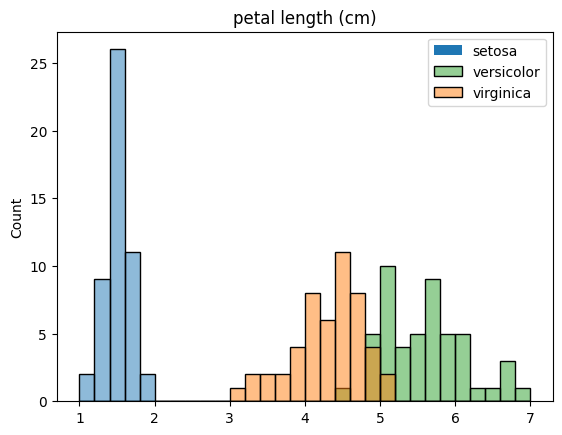

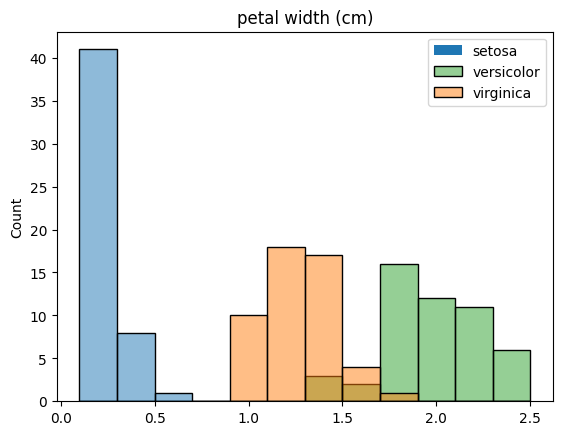

In [160]:
reduced_data2 = np.delete(reduced_data, 0, 1)
reduced_feature_names2 = np.delete(reduced_feature_names, 0, 0)

for i in range(len(reduced_feature_names2)):
    sns.histplot(reduced_data2[:, i].reshape(3, 50).T, binwidth=0.2)
    plt.legend(iris.target_names)
    plt.title(reduced_feature_names2[i])
    plt.show()

### Train on only one feature, test both petal width and length

Fitting converged after 2967 iterations.
[[ 1.77804747 -3.29228202 -1.76327524]
 [-0.99557634  1.68098463 -2.58978165]
 [-3.94720676  4.58845699  3.66760834]] [ 0.63528431  1.75048125 -3.617762  ]


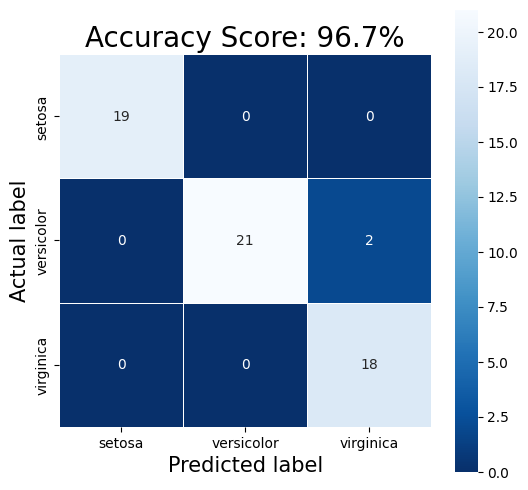

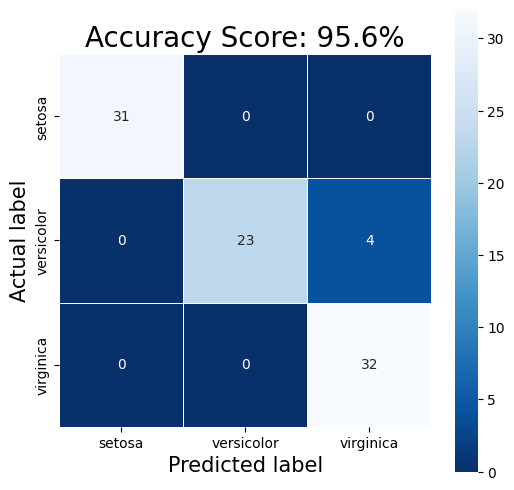

In [161]:
classifier = MSELinearClassifier()

classifier.fit(training_data, training_labels)

print(classifier.w, classifier.offset)


pred = classifier.predict(test_data, get_class = True)
score = classifier.score(test_data, test_labels)
conf_matrix = confusion_matrix(test_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="test_set_confusion_matrix.png")

pred = classifier.predict(training_data, get_class = True)
score = classifier.score(training_data, training_labels)
conf_matrix = confusion_matrix(training_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="training_set_confusion_matrix.png")

In [162]:
training_data, test_data, training_labels, test_labels = train_test_split(iris.data[:, 2], iris.target, test_size=0.4)

Fitting converged after 6051 iterations.
[[-3.16780039]
 [ 0.18516185]
 [ 2.97900734]] [  7.82219062  -1.41453399 -14.25009924]


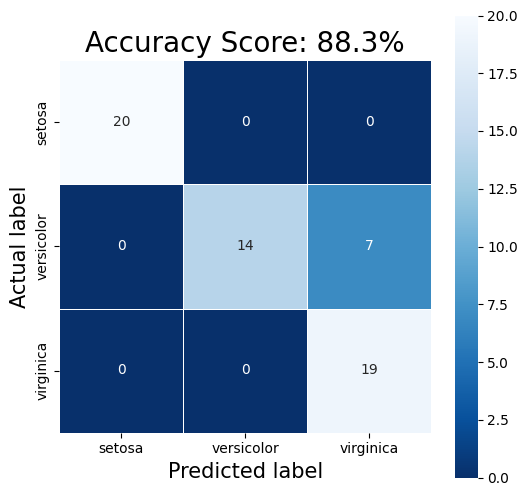

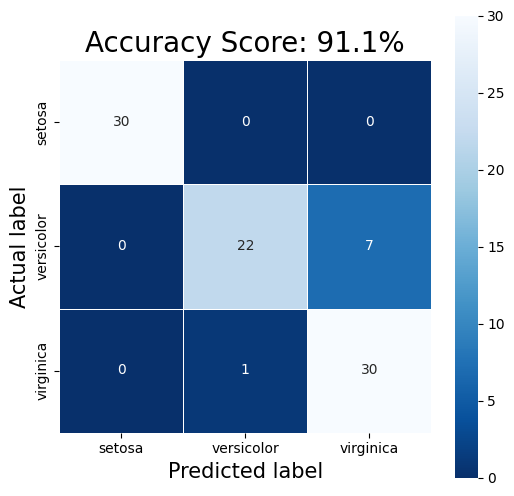

In [163]:
classifier = MSELinearClassifier()

classifier.fit(training_data, training_labels)

print(classifier.w, classifier.offset)


pred = classifier.predict(test_data, get_class = True)
score = classifier.score(test_data, test_labels)
conf_matrix = confusion_matrix(test_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="test_set_confusion_matrix.png")

pred = classifier.predict(training_data, get_class = True)
score = classifier.score(training_data, training_labels)
conf_matrix = confusion_matrix(training_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="training_set_confusion_matrix.png")

In [166]:
training_data, test_data, training_labels, test_labels = train_test_split(iris.data[:, 3], iris.target, test_size=0.4)

Fitting converged after 4442 iterations.
[[-6.93416738]
 [ 0.18999863]
 [ 6.14730432]] [  5.0639419   -0.78106972 -10.2930377 ]


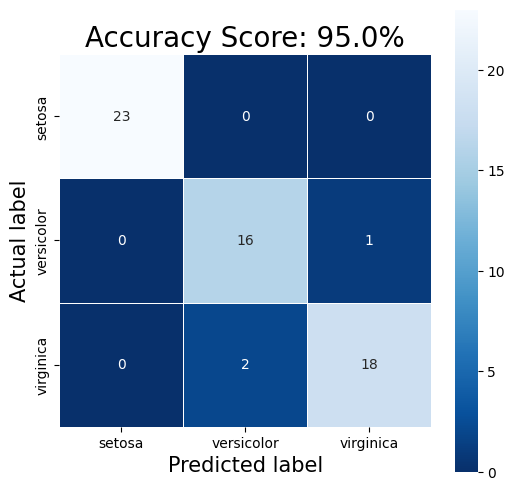

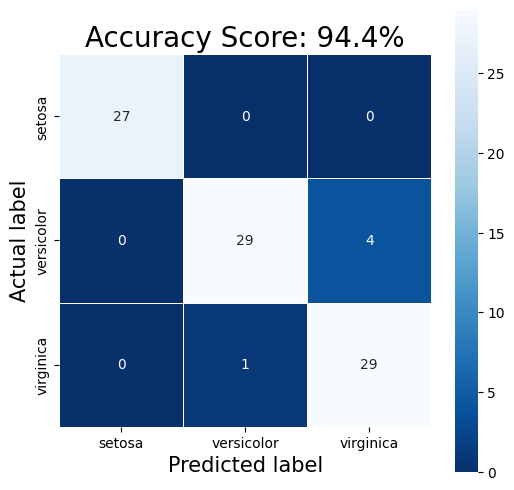

In [167]:
classifier = MSELinearClassifier()

classifier.fit(training_data, training_labels)

print(classifier.w, classifier.offset)


pred = classifier.predict(test_data, get_class = True)
score = classifier.score(test_data, test_labels)
conf_matrix = confusion_matrix(test_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="test_set_confusion_matrix.png")

pred = classifier.predict(training_data, get_class = True)
score = classifier.score(training_data, training_labels)
conf_matrix = confusion_matrix(training_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="training_set_confusion_matrix.png")

### To compare, here trained on presumed worst feature

In [170]:
training_data, test_data, training_labels, test_labels = train_test_split(iris.data[:, 1], iris.target, test_size=0.4)

Fitting converged after 5171 iterations.
[[ 3.82678051]
 [-2.8611256 ]
 [-0.61569781]] [-12.52248364   7.88108765   1.19413514]


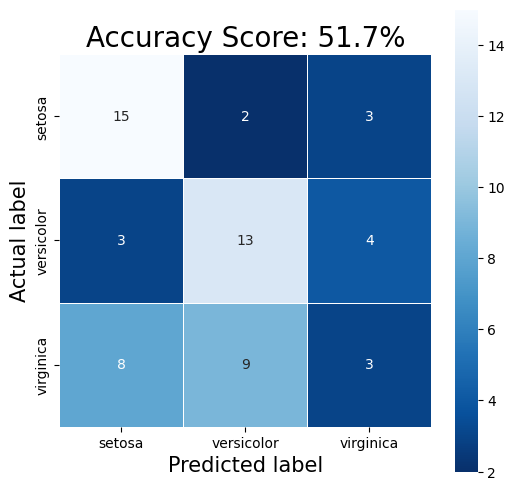

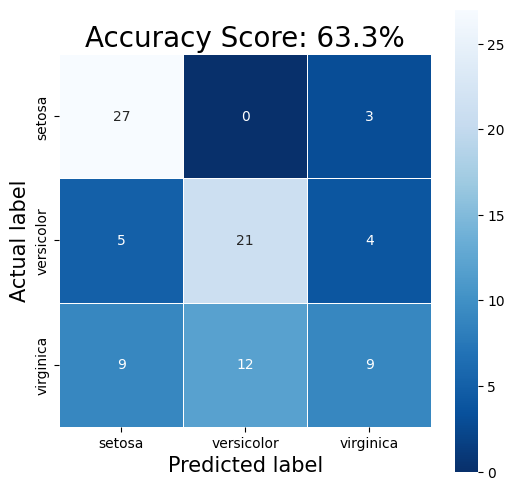

In [171]:
classifier = MSELinearClassifier()

classifier.fit(training_data, training_labels)

print(classifier.w, classifier.offset)


pred = classifier.predict(test_data, get_class = True)
score = classifier.score(test_data, test_labels)
conf_matrix = confusion_matrix(test_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="test_set_confusion_matrix.png")

pred = classifier.predict(training_data, get_class = True)
score = classifier.score(training_data, training_labels)
conf_matrix = confusion_matrix(training_labels, pred)
plot_confusion_matrix(conf_matrix, score, filename="training_set_confusion_matrix.png")

## Misc

### SKlearn classifiers for comparison

In [175]:
def linearClassification(classifier):
    name = classifier.__class__.__name__ 
    classifier.fit(training_data, training_labels)
    print("--------" + name + "--------")
   
    score = classifier.score(test_data, test_labels)
    print("Accuracy:", score*100, "%")

    return score, name

In [176]:
training_data, test_data, training_labels, test_labels = train_test_split(iris.data, iris.target, test_size=0.4) #split the set in 3/5 training and 2/5 test

In [177]:
from sklearn.linear_model import LogisticRegression, Perceptron, PassiveAggressiveClassifier, RidgeClassifier
from sklearn.svm import LinearSVC

classifiers = [LinearSVC(), LogisticRegression(), Perceptron(), PassiveAggressiveClassifier(), RidgeClassifier()]

scores = []
names = []

for c in classifiers:
    score, name = linearClassification(c)
    scores.append(score)
    names.append(name)

--------LinearSVC--------
Accuracy: 96.66666666666667 %
--------LogisticRegression--------
Accuracy: 96.66666666666667 %
--------Perceptron--------
Accuracy: 68.33333333333333 %
--------PassiveAggressiveClassifier--------
Accuracy: 96.66666666666667 %
--------RidgeClassifier--------
Accuracy: 81.66666666666667 %


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
